# **Imports**

In [8]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
import torchprofile

import time
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
def save_for_plot(data, name):
    e = np.asarray(data)
    with open("./Results/"+ name + ".csv", "w") as fe:
        np.savetxt(fe, e, delimiter=",")

In [3]:
inputs = torch.randn(500, 2, 128)
MACs = torchprofile.profile_macs(blNet, inputs)
#print("FLOPs: {:.2f}G".format(flops / 1e9))
print(MACs)

inputs = torch.randn(5, 2, 128).to(device)
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=False) as prof:
    with record_function("model_inference"):
        blNet(inputs)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

NameError: name 'blNet' is not defined

# **Data**

In [10]:
dataHandler = getData(0.1)

Training:  (340200, 2, 128) (340200, 2)
Validation:  (37800, 2, 128) (37800, 2)
Testing:  (42000, 2, 128) (42000, 2)


In [11]:
trainLoader, valLoader, testLoader = dataHandler.get_loaders()

# **Baseline Model**

In [12]:
NUM_EPOCHS = 50

In [13]:
bl_initialWeights = "./models/intialized_bl_0420.pth"
blNet = blModel().to(device)
blNet.load_state_dict(torch.load(bl_initialWeights))
optimizer_bl = optim.Adam(blNet.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer_bl, 50, verbose=True)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

Adjusting learning rate of group 0 to 1.0000e-04.


In [14]:
bl_titleToday = "./models/best_bl_0502.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
blNet, blHistory = BL.train(trainLoader, valLoader)
#blNet.load_state_dict(torch.load("./models/best_bl_0426.pth"))
blNet.load_state_dict(torch.load(bl_titleToday))

epoch 1 --> trainLoss: 1.270, trainAcc: 0.490, validLoss: 1.160, validAcc: 0.519
Model Saved!
epoch 2 --> trainLoss: 1.088, trainAcc: 0.556, validLoss: 1.038, validAcc: 0.572
Model Saved!
epoch 3 --> trainLoss: 1.041, trainAcc: 0.569, validLoss: 1.013, validAcc: 0.578
Model Saved!
epoch 4 --> trainLoss: 1.018, trainAcc: 0.575, validLoss: 1.005, validAcc: 0.579
Model Saved!
epoch 5 --> trainLoss: 1.003, trainAcc: 0.581, validLoss: 0.999, validAcc: 0.581
Model Saved!
epoch 6 --> trainLoss: 0.992, trainAcc: 0.586, validLoss: 0.998, validAcc: 0.584
Model Saved!
epoch 7 --> trainLoss: 0.984, trainAcc: 0.589, validLoss: 0.980, validAcc: 0.589
Model Saved!
epoch 8 --> trainLoss: 0.977, trainAcc: 0.592, validLoss: 0.980, validAcc: 0.591
Model Saved!
epoch 9 --> trainLoss: 0.971, trainAcc: 0.594, validLoss: 0.991, validAcc: 0.587
epoch 10 --> trainLoss: 0.967, trainAcc: 0.596, validLoss: 0.972, validAcc: 0.596
Model Saved!
epoch 11 --> trainLoss: 0.962, trainAcc: 0.598, validLoss: 0.981, validA

<All keys matched successfully>

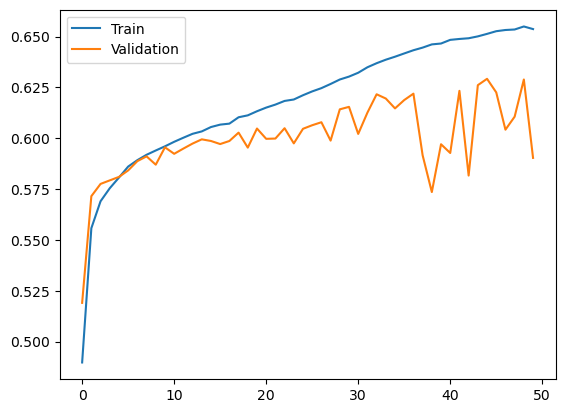

In [15]:
fig = plt.Figure()

x = [x for x in range(NUM_EPOCHS)]
plt.plot(x, blHistory["train"]["accuracy"])
plt.plot(x, blHistory["validation"]["accuracy"])
plt.legend(["Train", "Validation"])
plt.show()

# **EE Model**

In [16]:
eeV0_initialWeights = "./models/intialized_eeV0_0424_after.pth"
eeV1_initialWeights = "./models/intialized_eeV1_0424_after.pth"
eeV2_initialWeights = "./models/intialized_eeV2_0424_after.pth"
eeV3_initialWeights = "./models/intialized_eeV3_0501_after.pth"
eeV4_initialWeights = "./models/intialized_eeV4_0501_after.pth"

## Training V0

In [17]:
V0_titleToday = "./models/best_eeV0_0501_night.pth"
eeNet_V0 = eeModel_V0().to(device)
eeNet_V0.load_state_dict(torch.load(eeV0_initialWeights))

optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V0 = CosineAnnealingLR(optimizer_ee_V0, 50, verbose=True)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()

EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)
eeNet_V0, eeHistory_V0 = EE_V0.train(trainLoader, valLoader)
eeNet_V0.load_state_dict(torch.load(V0_titleToday))
#eeNet_V0.load_state_dict(torch.load("./models/best_eeV0_0426.pth"))

Number of base parameters: 576
Number of short branch parameters: 68010
Number of long branch parameters: 118842
Difference = 50832
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.608, trainAcc: 0.376, validLoss: 1.605, validAcc: 0.376
Model Saved!
epoch 2 --> trainLoss: 1.520, trainAcc: 0.408, validLoss: 1.559, validAcc: 0.398
Model Saved!
epoch 3 --> trainLoss: 1.471, trainAcc: 0.426, validLoss: 1.503, validAcc: 0.417
Model Saved!
epoch 4 --> trainLoss: 1.445, trainAcc: 0.434, validLoss: 1.449, validAcc: 0.434
Model Saved!
epoch 5 --> trainLoss: 1.425, trainAcc: 0.442, validLoss: 1.401, validAcc: 0.452
Model Saved!
epoch 6 --> trainLoss: 1.407, trainAcc: 0.449, validLoss: 1.384, validAcc: 0.456
Model Saved!
epoch 7 --> trainLoss: 1.390, trainAcc: 0.455, validLoss: 1.363, validAcc: 0.466
Model Saved!
epoch 8 --> trainLoss: 1.374, trainAcc: 0.461, validLoss: 1.339, validAcc: 0.476
Model Saved!
epoch 9 --> trainLoss: 1.357, trainAcc: 0.467, validLoss: 1.325, v

<All keys matched successfully>

In [18]:
eeRecorder_V0, preds_V0, acc_V0 = EE_V0.infer(valLoader, threshold=0.05, verbose=False)
EE_V0.testingSummary(eeRecorder_V0, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 100.00% with 1.03% of the samples
Branch 2: Accuracy 62.43% with 98.97% of the samples
Overall Weighted Accuracy: 62.81%


## Training V1

In [19]:
V1_titleToday = "./models/best_eeV1_0502_night.pth"
eeNet_V1 = eeModel_V1().to(device)
eeNet_V1.load_state_dict(torch.load(eeV1_initialWeights))

optimizer_ee_V1 = optim.Adam(eeNet_V1.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V1 = nn.CrossEntropyLoss()
scheduler_V1 = CosineAnnealingLR(optimizer_ee_V1, 50, verbose=True)
scheduler_V1 = None

EE_V1 = eeHandler(eeNet_V1, criterion_ee_V1, optimizer_ee_V1, device, scheduler=scheduler_V1, num_epochs=NUM_EPOCHS, bestPath=V1_titleToday)
eeNet_V1, eeHistory_V1 = EE_V1.train(trainLoader, valLoader)
eeNet_V1.load_state_dict(torch.load(V1_titleToday))
#eeNet_V1.load_state_dict(torch.load("./models/best_eeV1_0426.pth"))

Number of base parameters: 13056
Number of short branch parameters: 68010
Number of long branch parameters: 106362
Difference = 38352
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.388, trainAcc: 0.458, validLoss: 1.769, validAcc: 0.402
Model Saved!
epoch 2 --> trainLoss: 1.256, trainAcc: 0.506, validLoss: 1.446, validAcc: 0.482
Model Saved!
epoch 3 --> trainLoss: 1.193, trainAcc: 0.531, validLoss: 1.311, validAcc: 0.519
Model Saved!
epoch 4 --> trainLoss: 1.161, trainAcc: 0.543, validLoss: 1.195, validAcc: 0.539
Model Saved!
epoch 5 --> trainLoss: 1.141, trainAcc: 0.552, validLoss: 1.159, validAcc: 0.550
Model Saved!
epoch 6 --> trainLoss: 1.127, trainAcc: 0.558, validLoss: 1.095, validAcc: 0.567
Model Saved!
epoch 7 --> trainLoss: 1.114, trainAcc: 0.562, validLoss: 1.081, validAcc: 0.572
Model Saved!
epoch 8 --> trainLoss: 1.106, trainAcc: 0.565, validLoss: 1.067, validAcc: 0.576
Model Saved!
epoch 9 --> trainLoss: 1.097, trainAcc: 0.568, validLoss: 1.079,

<All keys matched successfully>

In [20]:
eeRecorder_V1, preds_V1, acc_V1 = EE_V1.infer(valLoader, threshold=0.05, verbose=False)
EE_V1.testingSummary(eeRecorder_V1, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 100.00% with 20.72% of the samples
Branch 2: Accuracy 52.35% with 79.28% of the samples
Overall Weighted Accuracy: 62.22%


## Training V2

In [21]:
V2_titleToday = "./models/best_eeV2_0502_night.pth"

eeNet_V2 = eeModel_V2().to(device)
eeNet_V2.load_state_dict(torch.load(eeV2_initialWeights))

optimizer_ee_V2 = optim.Adam(eeNet_V2.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V2 = nn.CrossEntropyLoss()
scheduler_V2 = CosineAnnealingLR(optimizer_ee_V2, 50, verbose=True)
scheduler_V2 = None

EE_V2 = eeHandler(eeNet_V2, criterion_ee_V2, optimizer_ee_V2, device, scheduler=scheduler_V2, num_epochs=NUM_EPOCHS, bestPath=V2_titleToday)
eeNet_V2, eeHistory_V2 = EE_V2.train(trainLoader, valLoader)
eeNet_V2.load_state_dict(torch.load(V2_titleToday))
#eeNet_V2.load_state_dict(torch.load("./models/best_eeV2_0426.pth"))

Number of base parameters: 34944
Number of short branch parameters: 68010
Number of long branch parameters: 84474
Difference = 16464
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.206, trainAcc: 0.518, validLoss: 1.210, validAcc: 0.528
Model Saved!
epoch 2 --> trainLoss: 1.099, trainAcc: 0.550, validLoss: 1.113, validAcc: 0.553
Model Saved!
epoch 3 --> trainLoss: 1.059, trainAcc: 0.562, validLoss: 1.077, validAcc: 0.565
Model Saved!
epoch 4 --> trainLoss: 1.037, trainAcc: 0.570, validLoss: 1.022, validAcc: 0.578
Model Saved!
epoch 5 --> trainLoss: 1.021, trainAcc: 0.577, validLoss: 1.027, validAcc: 0.579
epoch 6 --> trainLoss: 1.011, trainAcc: 0.581, validLoss: 0.995, validAcc: 0.585
Model Saved!
epoch 7 --> trainLoss: 1.002, trainAcc: 0.585, validLoss: 0.985, validAcc: 0.590
Model Saved!
epoch 8 --> trainLoss: 0.995, trainAcc: 0.587, validLoss: 0.977, validAcc: 0.594
Model Saved!
epoch 9 --> trainLoss: 0.989, trainAcc: 0.589, validLoss: 0.976, validAcc: 0.5

<All keys matched successfully>

In [22]:
eeRecorder_V2, preds_V2, acc_V2 = EE_V2.infer(valLoader, threshold=0.05, verbose=False)
EE_V2.testingSummary(eeRecorder_V2, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.95% with 30.35% of the samples
Branch 2: Accuracy 46.90% with 69.65% of the samples
Overall Weighted Accuracy: 63.01%


# Training V3

In [23]:
V3_titleToday = "./models/best_eeV3_0502_night.pth"
eeNet_V3 = eeModel_V3().to(device)
eeNet_V3.load_state_dict(torch.load(eeV3_initialWeights))

optimizer_ee_V3 = optim.Adam(eeNet_V3.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V3 = CosineAnnealingLR(optimizer_ee_V3, 50, verbose=True)
scheduler_V3 = None
criterion_ee_V3 = nn.CrossEntropyLoss()

EE_V3 = eeHandler(eeNet_V3, criterion_ee_V3, optimizer_ee_V3, device, scheduler=scheduler_V3, num_epochs=NUM_EPOCHS, bestPath=V3_titleToday)
eeNet_V3, eeHistory_V3 = EE_V3.train(trainLoader, valLoader)
eeNet_V3.load_state_dict(torch.load(V3_titleToday))
#eeNet_V0.load_state_dict(torch.load("./models/best_eeV0_0426.pth"))

Number of base parameters: 34944
Number of short branch parameters: 68010
Number of long branch parameters: 90810
Difference = 22800
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.246, trainAcc: 0.504, validLoss: 1.134, validAcc: 0.541
Model Saved!
epoch 2 --> trainLoss: 1.100, trainAcc: 0.552, validLoss: 1.076, validAcc: 0.561
Model Saved!
epoch 3 --> trainLoss: 1.056, trainAcc: 0.566, validLoss: 1.065, validAcc: 0.560
Model Saved!
epoch 4 --> trainLoss: 1.033, trainAcc: 0.575, validLoss: 1.024, validAcc: 0.580
Model Saved!
epoch 5 --> trainLoss: 1.018, trainAcc: 0.581, validLoss: 0.994, validAcc: 0.588
Model Saved!
epoch 6 --> trainLoss: 1.009, trainAcc: 0.585, validLoss: 0.986, validAcc: 0.591
Model Saved!
epoch 7 --> trainLoss: 1.001, trainAcc: 0.588, validLoss: 0.985, validAcc: 0.593
Model Saved!
epoch 8 --> trainLoss: 0.993, trainAcc: 0.591, validLoss: 0.974, validAcc: 0.596
Model Saved!
epoch 9 --> trainLoss: 0.988, trainAcc: 0.594, validLoss: 0.972, 

<All keys matched successfully>

In [25]:
eeRecorder_V3, preds_V3, acc_V3 = EE_V3.infer(valLoader, threshold=0.05, verbose=False)
EE_V3.testingSummary(eeRecorder_V3, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.90% with 32.50% of the samples
Branch 2: Accuracy 45.58% with 67.50% of the samples
Overall Weighted Accuracy: 63.24%


# Training V4

In [24]:
V4_titleToday = "./models/best_eeV4_0502_night.pth"
eeNet_V4 = eeModel_V4().to(device)
eeNet_V4.load_state_dict(torch.load(eeV4_initialWeights))

optimizer_ee_V4 = optim.Adam(eeNet_V4.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V4 = CosineAnnealingLR(optimizer_ee_V4, 50, verbose=True)
scheduler_V4 = None
criterion_ee_V4 = nn.CrossEntropyLoss()

EE_V4 = eeHandler(eeNet_V4, criterion_ee_V4, optimizer_ee_V4, device, scheduler=scheduler_V4, num_epochs=NUM_EPOCHS, bestPath=V4_titleToday)
eeNet_V4, eeHistory_V4 = EE_V4.train(trainLoader, valLoader)
eeNet_V4.load_state_dict(torch.load(V4_titleToday))
#eeNet_V0.load_state_dict(torch.load("./models/best_eeV0_0426.pth"))

Number of base parameters: 25536
Number of short branch parameters: 68010
Number of long branch parameters: 93882
Difference = 25872
Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 --> trainLoss: 1.288, trainAcc: 0.488, validLoss: 1.273, validAcc: 0.501
Model Saved!
epoch 2 --> trainLoss: 1.159, trainAcc: 0.533, validLoss: 1.113, validAcc: 0.551
Model Saved!
epoch 3 --> trainLoss: 1.107, trainAcc: 0.550, validLoss: 1.059, validAcc: 0.566
Model Saved!
epoch 4 --> trainLoss: 1.081, trainAcc: 0.559, validLoss: 1.060, validAcc: 0.563
epoch 5 --> trainLoss: 1.061, trainAcc: 0.566, validLoss: 1.026, validAcc: 0.576
Model Saved!
epoch 6 --> trainLoss: 1.049, trainAcc: 0.571, validLoss: 1.020, validAcc: 0.577
Model Saved!
epoch 7 --> trainLoss: 1.038, trainAcc: 0.575, validLoss: 1.016, validAcc: 0.582
Model Saved!
epoch 8 --> trainLoss: 1.030, trainAcc: 0.578, validLoss: 1.010, validAcc: 0.580
Model Saved!
epoch 9 --> trainLoss: 1.024, trainAcc: 0.580, validLoss: 1.004, validAcc: 0.5

<All keys matched successfully>

In [26]:
eeRecorder_V4, preds_V4, acc_V4 = EE_V4.infer(valLoader, threshold=0.05, verbose=False)
EE_V4.testingSummary(eeRecorder_V4, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 100.00% with 25.87% of the samples
Branch 2: Accuracy 48.68% with 74.13% of the samples
Overall Weighted Accuracy: 61.96%


# SNR Experiments

In [50]:
snrs = dataHandler.get_snrs()
trainXs, valXs, testXs = dataHandler.get_Xs()
trainLabels, valLabels, testLabels = dataHandler.get_labels()
label_dict = dataHandler.get_label_dict()

stringSNRs = ['{}'.format(x) for x in snrs]
thresholds = [0.05, 0.15, 0.3, 0.4]
nBranches = 2

accuracies = {typ: {thre:{y: 0 for y in stringSNRs} for thre in thresholds} for typ in ["Baseline", "V0", "V1", "V2", "V3", "V4"]}
inferenceCounter = {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in thresholds} for y in ["V0", "V1", "V2", "V3", "V4"]}

In [51]:
# V3 --> V4
# V4 --> V2
# V2 --> V3

In [52]:
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
    tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies["V0"][thre][snr] = eeAcc_V0

        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies["V1"][thre][snr] = eeAcc_V1

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies["V3"][thre][snr] = eeAcc_V2
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies["V4"][thre][snr] = eeAcc_V3
        
        recorder_V4, _, eeAcc_V4 = EE_V4.infer(tmpLoader, threshold=thre)
        accuracies["V2"][thre][snr] = eeAcc_V4
    
        for i in range(nBranches):
            inferenceCounter["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter["V3"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter["V4"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100
            inferenceCounter["V2"][thre][i][snr] = len(recorder_V4[i])/(len(recorder_V4[0])+len(recorder_V4[1]))*100
            
    print("Done with SNR = {}".format(snr))

Done with SNR = -20
Done with SNR = -18
Done with SNR = -16
Done with SNR = -14
Done with SNR = -12
Done with SNR = -10
Done with SNR = -8
Done with SNR = -6
Done with SNR = -4
Done with SNR = -2
Done with SNR = 0
Done with SNR = 2
Done with SNR = 4
Done with SNR = 6
Done with SNR = 8
Done with SNR = 10
Done with SNR = 12
Done with SNR = 14
Done with SNR = 16
Done with SNR = 18
Done with SNR = 20


# Accuracy

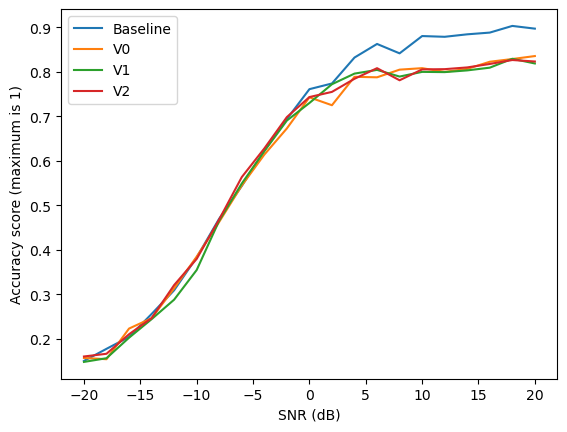

In [53]:
#thresholds = [0.05, 0.15, 0.3, 0.4]
figTitles = ['./Figures/accuracy_005_V012.png', './Figures/accuracy_015_V012.png', './Figures/accuracy_03_V012.png', './Figures/accuracy_04_V012.png']
i = 3
THRESHOLD = thresholds[i]
figTitle = figTitles[i]
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(accuracies["Baseline"][0.05].values()));
plt.plot(xAxis, list(accuracies["V0"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V1"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V2"][THRESHOLD].values()));
#plt.plot(xAxis, list(accuracies["V3"][THRESHOLD].values()));
#plt.plot(xAxis, list(accuracies["V4"][THRESHOLD].values()));
plt.legend(["Baseline", "V0", "V1", "V2"])
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy score (maximum is 1)')
#plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.savefig(figTitle)
plt.show()

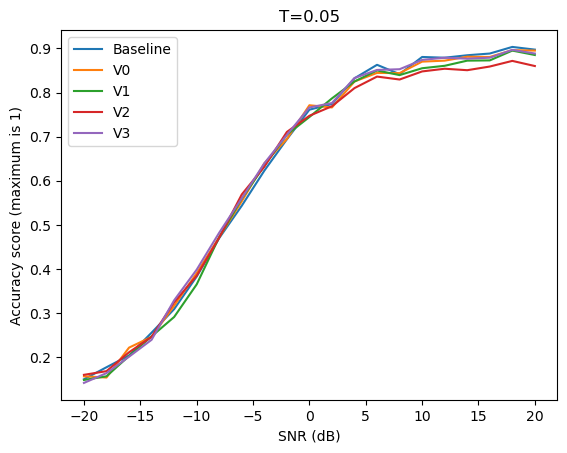

In [401]:
thresholds = [0.05, 0.15, 0.3, 0.4]
figTitles = ['./Figures/accuracy_005_V01234.png', './Figures/accuracy_015_V01234.png', './Figures/accuracy_03_V01234.png', './Figures/accuracy_04_V01234.png']
i = 0
THRESHOLD = thresholds[i]
figTitle = figTitles[i]
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(accuracies["Baseline"][0.05].values()));
plt.plot(xAxis, list(accuracies["V0"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V1"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V2"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V3"][THRESHOLD].values()));
#plt.plot(xAxis, list(accuracies["V4"][THRESHOLD].values()));

plt.legend(["Baseline", "V0", "V1", "V2", "V3"])
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy score (maximum is 1)')
plt.title('T={}'.format(THRESHOLD))
#plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.savefig(figTitle)
plt.show()

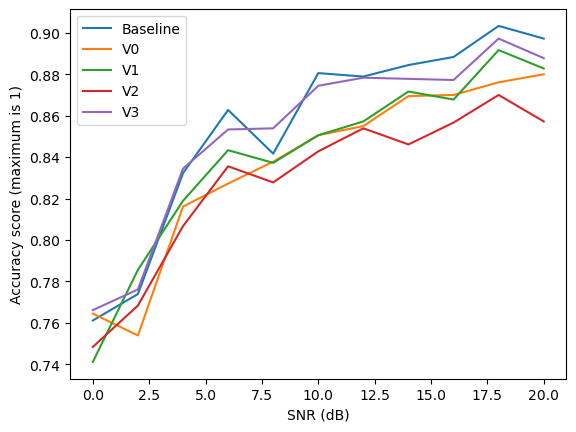

In [394]:
#thresholds = [0.05, 0.15, 0.3, 0.4]
i = 2
THRESHOLD = thresholds[i]
figTitle = figTitles[i]
fig = plt.Figure()
FR = 10
xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis[FR:], list(accuracies["Baseline"][0.05].values())[FR:]);
plt.plot(xAxis[FR:], list(accuracies["V0"][THRESHOLD].values())[FR:]);
plt.plot(xAxis[FR:], list(accuracies["V1"][THRESHOLD].values())[FR:]);
plt.plot(xAxis[FR:], list(accuracies["V2"][THRESHOLD].values())[FR:]);
plt.plot(xAxis[FR:], list(accuracies["V3"][THRESHOLD].values())[FR:]);
#plt.plot(xAxis, list(accuracies["V4"][THRESHOLD].values()));

plt.legend(["Baseline", "V0", "V1", "V2", "V3"])
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy score (maximum is 1)')
#plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.savefig('./Figures/accuracy_zoomed.png')
plt.show()

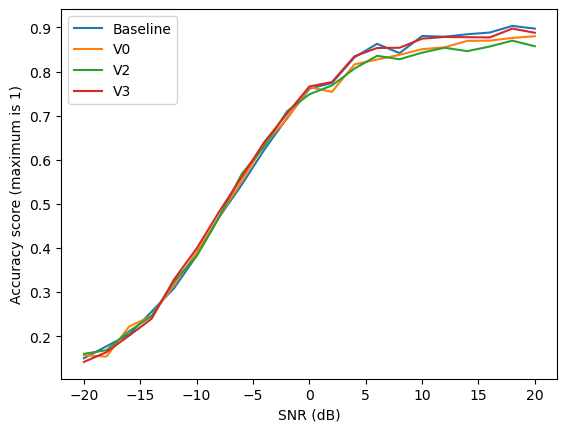

In [77]:
#thresholds = [0.05, 0.15, 0.3, 0.4]
figTitles = ['./Figures/accuracy_005_V023.png', './Figures/accuracy_015_V023.png', './Figures/accuracy_03_V023.png', './Figures/accuracy_04_V023.png']
i = 2
THRESHOLD = thresholds[i]
figTitle = figTitles[i]
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(accuracies["Baseline"][0.05].values()));
plt.plot(xAxis, list(accuracies["V0"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V2"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V3"][THRESHOLD].values()));

plt.legend(["Baseline", "V0", "V2", "V3"])
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy score (maximum is 1)')
#plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.savefig(figTitle)
plt.show()

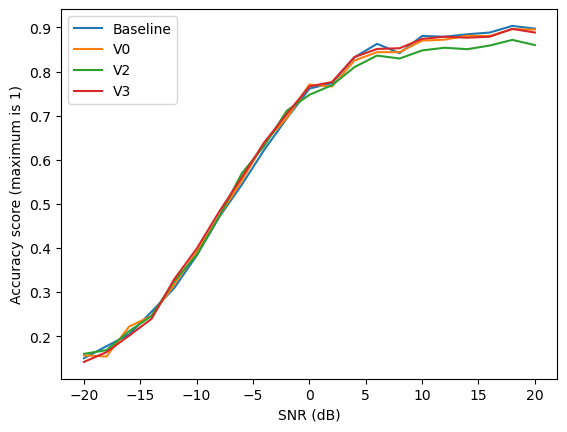

In [78]:
#thresholds = [0.05, 0.15, 0.3, 0.4]
figTitles = ['./Figures/accuracy_005_V023.png', './Figures/accuracy_015_V023.png', './Figures/accuracy_03_V023.png', './Figures/accuracy_04_V023.png']
i = 1
THRESHOLD = thresholds[i]
figTitle = figTitles[i]
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(accuracies["Baseline"][0.05].values()));
plt.plot(xAxis, list(accuracies["V0"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V2"][THRESHOLD].values()));
plt.plot(xAxis, list(accuracies["V3"][THRESHOLD].values()));

plt.legend(["Baseline", "V0", "V2", "V3"])
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy score (maximum is 1)')
#plt.title("Accuracy Comparison with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.savefig(figTitle)
plt.show()

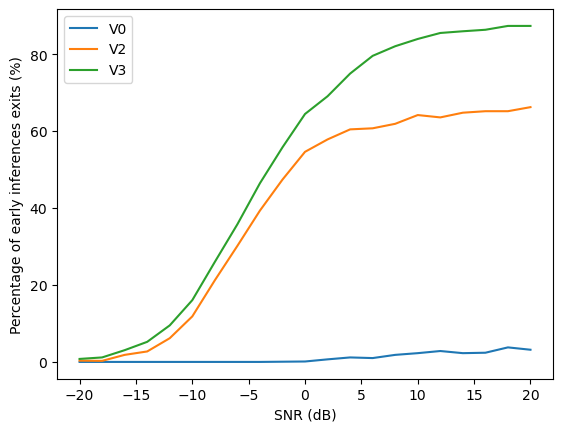

In [62]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["V0"][0.05][0].values()))
#plt.plot(xAxis, list(inferenceCounter["V1"][0.3][0].values()))
plt.plot(xAxis, list(inferenceCounter["V2"][0.3][0].values()))
plt.plot(xAxis, list(inferenceCounter["V3"][0.3][0].values()))
#plt.plot(xAxis, list(inferenceCounter["V4"][0.3][0].values()))

plt.legend(["V0","V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel('Percentage of early inferences exits (%)')
# Save the figure as a PNG file
plt.savefig('./Figures/percentage_compare_T03_V0234.png')

plt.show()



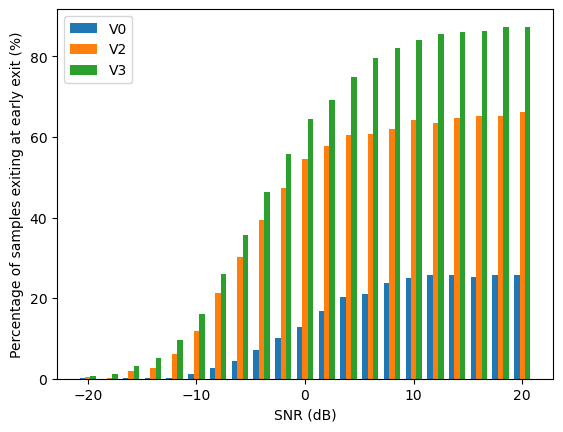

In [64]:
data0= list(inferenceCounter["V0"][0.3][0].values())
data1= list(inferenceCounter["V2"][0.3][0].values())
data2= list(inferenceCounter["V3"][0.3][0].values())

# Create a figure and axis object
fig, ax = plt.subplots()
bar_width = 0.5 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

# Plot the data as grouped bars
ax.bar(xAxis - bar_width, data0, width=bar_width, label='V0')
ax.bar(xAxis, data1, width=bar_width, label='V2')
ax.bar(xAxis + bar_width, data2, width=bar_width, label='V3')

# Set the axis labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Percentage of samples exiting at early exit (%)')
#ax.set_title('Grouped Bar Chart')

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Save the figure as a PNG file
fig.savefig('./Figures/percentage_compare_bar_V023.png')


In [72]:
# Total Number of Early Exitings


273.5

# Inference Counter

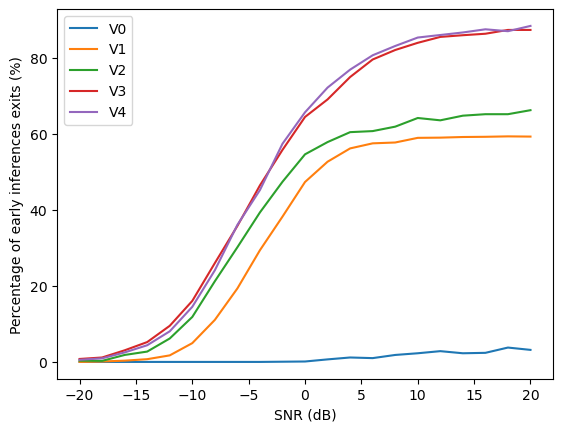

In [55]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["V0"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V1"][0.3][0].values()))
plt.plot(xAxis, list(inferenceCounter["V2"][0.3][0].values()))
plt.plot(xAxis, list(inferenceCounter["V3"][0.3][0].values()))
plt.plot(xAxis, list(inferenceCounter["V4"][0.3][0].values()))

plt.legend(["V0", "V1", "V2", "V3", "V4"])
plt.xlabel("SNR (dB)")
plt.ylabel('Percentage of early inferences exits (%)')
# Save the figure as a PNG file
plt.savefig('./Figures/percentage_compare_T03.png')

plt.show()



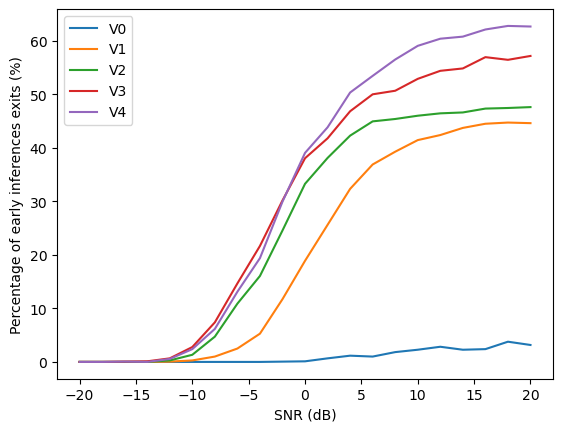

In [56]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["V0"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V1"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V2"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V3"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V4"][0.05][0].values()))

plt.legend(["V0", "V1", "V2", "V3", "V4"])
plt.xlabel("SNR (dB)")
plt.ylabel('Percentage of early inferences exits (%)')
# Save the figure as a PNG file
plt.savefig('./Figures/percentage_compare_T005.png')

plt.show()



# Inference Bar Plot

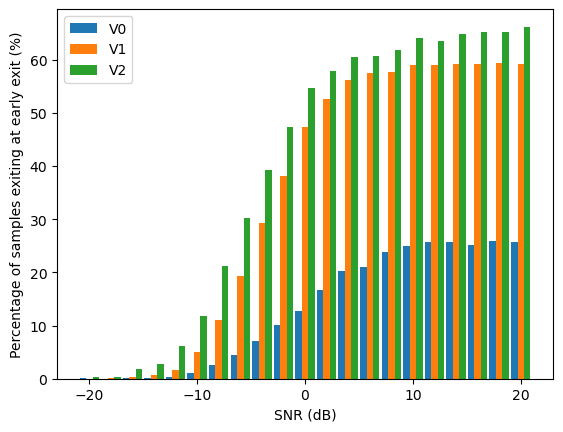

In [57]:
data0= list(inferenceCounter["V0"][0.3][0].values())
data1= list(inferenceCounter["V1"][0.3][0].values())
data2= list(inferenceCounter["V2"][0.3][0].values())

# Create a figure and axis object
fig, ax = plt.subplots()
bar_width = 0.6 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

# Plot the data as grouped bars
ax.bar(xAxis - bar_width, data0, width=bar_width, label='V0')
ax.bar(xAxis, data1, width=bar_width, label='V1')
ax.bar(xAxis + bar_width, data2, width=bar_width, label='V2')

# Set the axis labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Percentage of samples exiting at early exit (%)')
#ax.set_title('Grouped Bar Chart')

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Save the figure as a PNG file
fig.savefig('./Figures/percentage_compare_bar_V012.png')


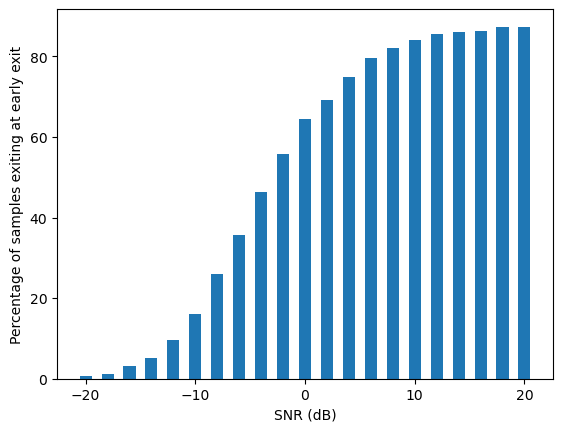

In [49]:
# Create a figure and axis object
fig, ax = plt.subplots()
bar_width = 1.1 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

# Plot the data as grouped bars
ax.bar(xAxis, inferenceCounter["V2"][0.3][0].values(), width=bar_width, label='short branch')
#ax.bar(xAxis + bar_width/2, inferenceCounter["V0"][0.15][1].values(), width=bar_width, label='long branch')

# Set the axis labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Percentage of samples exiting at early exit')
#ax.set_title('Grouped Bar Chart')

# Add a legend
#ax.legend()

# Show the plot
plt.show()

# Save the figure as a PNG file
fig.savefig('./Figures/percentage_V0_03.png')

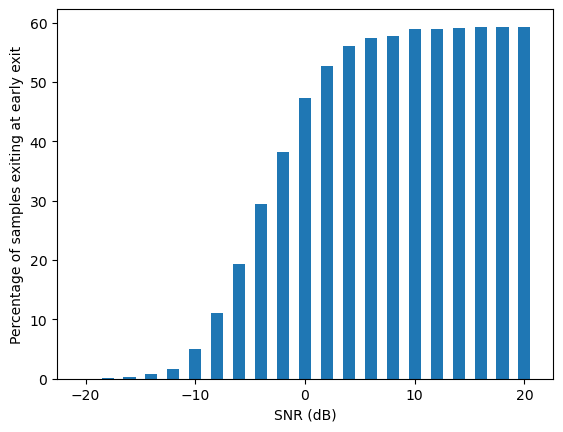

In [264]:
# Create a figure and axis object
fig, ax = plt.subplots()
bar_width = 1.1 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

# Plot the data as grouped bars
ax.bar(xAxis, inferenceCounter["V1"][0.3][0].values(), width=bar_width, label='short branch')
#ax.bar(xAxis + bar_width/2, inferenceCounter["V0"][0.15][1].values(), width=bar_width, label='long branch')

# Set the axis labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Percentage of samples exiting at early exit')
#ax.set_title('Grouped Bar Chart')

# Add a legend
#ax.legend()

# Show the plot
plt.show()

# Save the figure as a PNG file
fig.savefig('./Figures/percentage_V2_03.png')

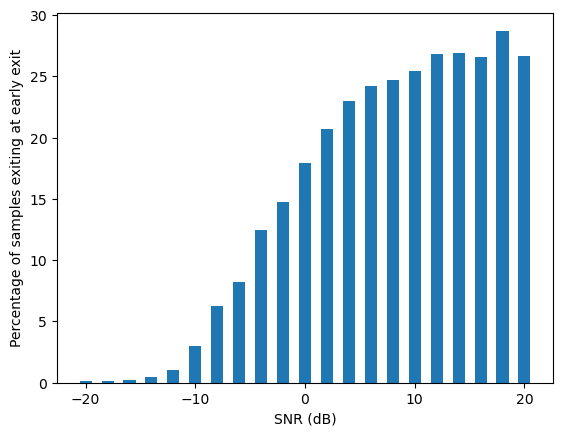

In [103]:
# Create a figure and axis object
fig, ax = plt.subplots()
bar_width = 1.1 # Set the width of each bar
xAxis = np.arange(-20, 21, 2) #SNRs

# Plot the data as grouped bars
ax.bar(xAxis, inferenceCounter["V0"][0.4][0].values(), width=bar_width, label='short branch')
#ax.bar(xAxis + bar_width/2, inferenceCounter["V0"][0.15][1].values(), width=bar_width, label='long branch')

# Set the axis labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Percentage of samples exiting at early exit')
#ax.set_title('Grouped Bar Chart')

# Add a legend
#ax.legend()

# Show the plot
plt.show()

# Save the figure as a PNG file
fig.savefig('./Figures/percentage_04.png')

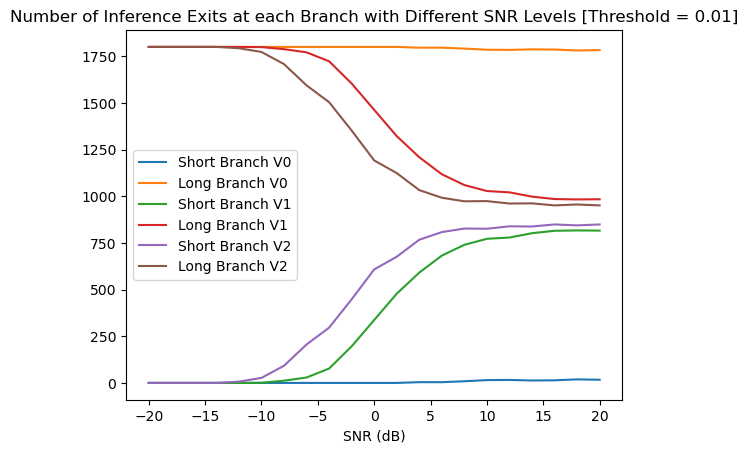

In [32]:
THRESHOLD = 0.01
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][1].values()))

plt.legend(["Short Branch V0", "Long Branch V0", "Short Branch V1", "Long Branch V1", "Short Branch V2", "Long Branch V2"])
plt.title("Number of Inference Exits at each Branch with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.xlabel("SNR (dB)")
plt.show()

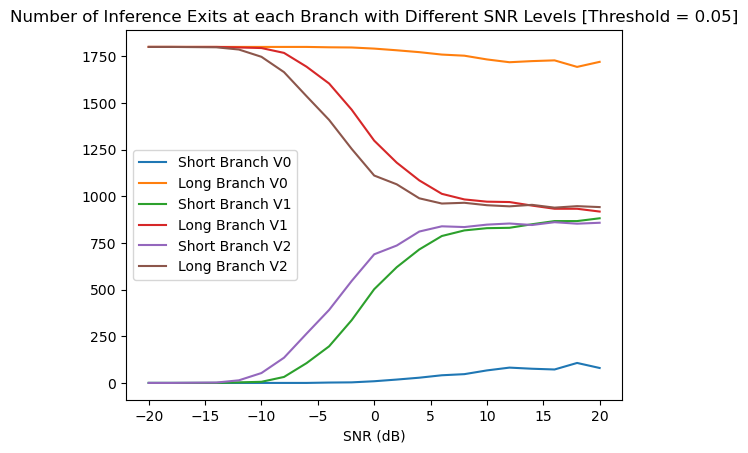

In [33]:
THRESHOLD = 0.05
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][1].values()))

plt.legend(["Short Branch V0", "Long Branch V0", "Short Branch V1", "Long Branch V1", "Short Branch V2", "Long Branch V2"])
plt.title("Number of Inference Exits at each Branch with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.xlabel("SNR (dB)")
plt.show()

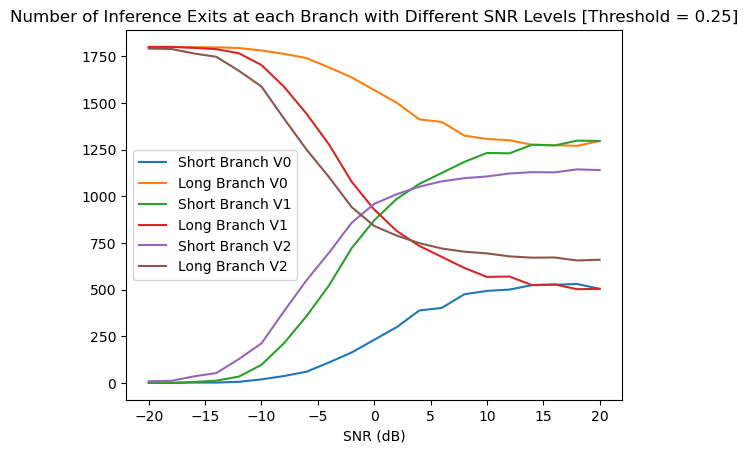

In [34]:
THRESHOLD = 0.25
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][1].values()))

plt.legend(["Short Branch V0", "Long Branch V0", "Short Branch V1", "Long Branch V1", "Short Branch V2", "Long Branch V2"])
plt.title("Number of Inference Exits at each Branch with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.xlabel("SNR (dB)")
plt.show()

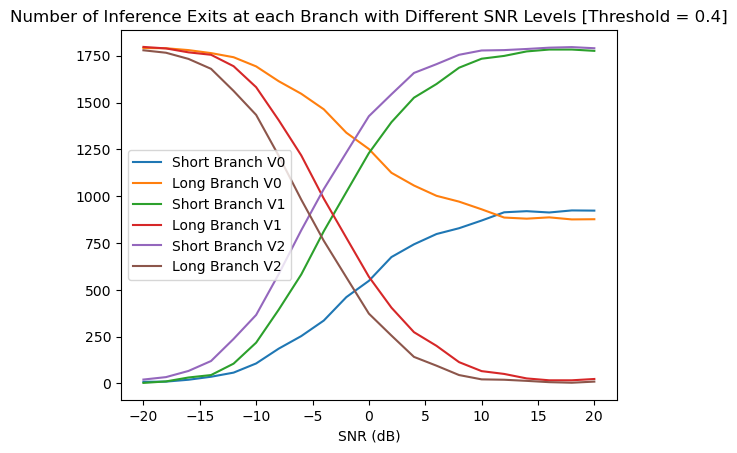

In [35]:
THRESHOLD = 0.4
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V0"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][THRESHOLD][1].values()))

plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V2"][THRESHOLD][1].values()))

plt.legend(["Short Branch V0", "Long Branch V0", "Short Branch V1", "Long Branch V1", "Short Branch V2", "Long Branch V2"])
plt.title("Number of Inference Exits at each Branch with Different SNR Levels [Threshold = {}]".format(THRESHOLD));
plt.xlabel("SNR (dB)")
plt.show()

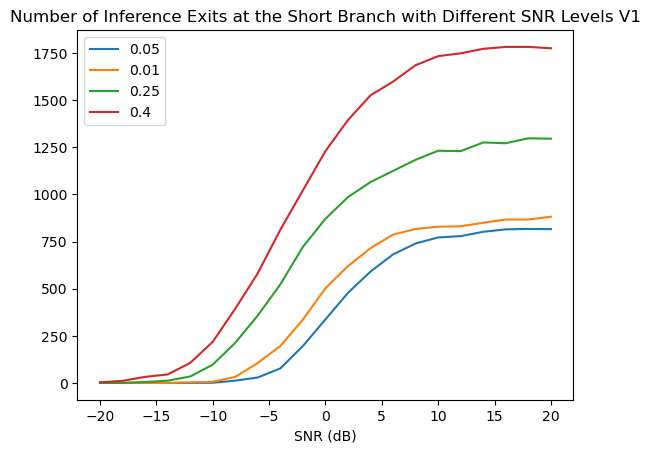

In [36]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V1"][0.01][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][0.25][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][0.4][0].values()))

plt.legend(["0.05", "0.01", "0.25", "0.4"])
plt.title("Number of Inference Exits at the Short Branch with Different SNR Levels V1");
plt.xlabel("SNR (dB)")
plt.show()

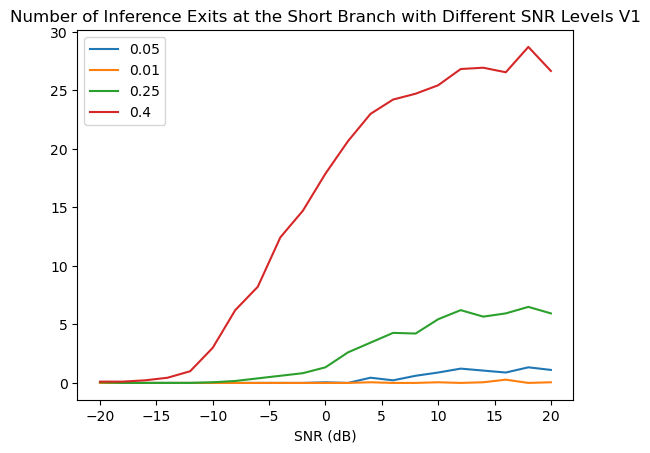

In [37]:

fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["V0"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["V0"][0.01][0].values()))
plt.plot(xAxis, list(inferenceCounter["V0"][0.25][0].values()))
plt.plot(xAxis, list(inferenceCounter["V0"][0.4][0].values()))

plt.legend(["0.05", "0.01", "0.25", "0.4"])
plt.title("Number of Inference Exits at the Short Branch with Different SNR Levels V1");
plt.xlabel("SNR (dB)")
plt.show()

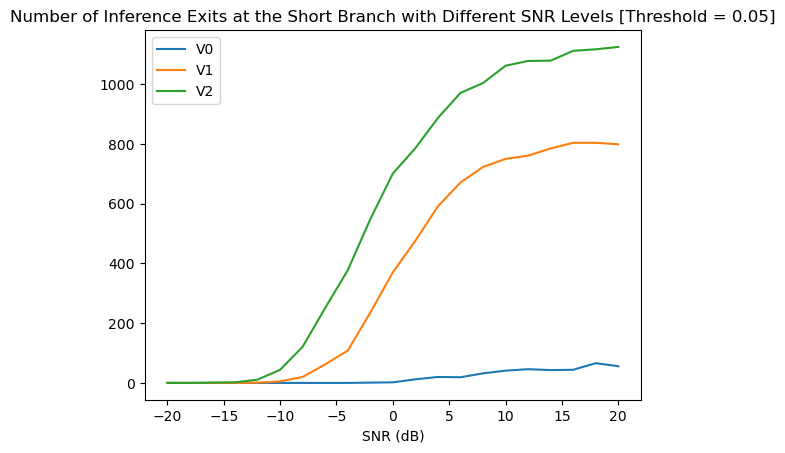

In [25]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs
plt.plot(xAxis, list(inferenceCounter["EE_V0"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V1"][0.05][0].values()))
plt.plot(xAxis, list(inferenceCounter["EE_V2"][0.05][0].values()))

plt.legend(["V0", "V1", "V2"])
plt.title("Number of Inference Exits at the Short Branch with Different SNR Levels [Threshold = 0.05]");
plt.xlabel("SNR (dB)")
plt.show()

# Experiments

## 1. Moving the branching more forward! [Closer to the main branch]

## 2. Timing Experiment

In [229]:
def forward_timeTest(net, sLoader, ratio=0.1):
        num_samples_to_select = int(ratio * 500)
        with torch.no_grad():
            net.eval()
            for inputs, _ in sLoader:
                inputs = inputs.to(device)
                selected_data = inputs[0: num_samples_to_select]
                remaining_data = inputs[num_samples_to_select: inputs.shape[0]]
                _ = net.short_forward(selected_data)
                _ = net.long_forward(remaining_data)


def late_inference(net, sLoader, threshold=0.05, verbose=False):
        """
        """
        softmaxLayer = nn.Softmax(dim=1)
        acc = 0
        predicted = []
        recorder = {x: [] for x in range(2)}
        
        with torch.no_grad():
            net.eval()
            for inputs, gTruth in sLoader:
                inputs, gTruth = inputs.to(device), gTruth.to(device)
                x = net.baseModel(inputs)
                for iSample in range(x.shape[0]): # a sample by sample
                    out1 = net.longBranch(x[iSample:iSample+1])
#                     y = softmaxLayer(out1)
#                     e = entropy(y.detach().cpu().numpy().squeeze(), base=10)
#                     if e <= threshold:
#                         if verbose:
#                             print(e)
#                         _, label = torch.max(out1, 1)
#                         predicted.append(label)
#                         if label == gTruth[iSample].item():
#                             recorder[0].append(1)
#                             acc+=1
#                         else:
#                             recorder[0].append(0)
#                         continue
# #                     out2 = net.longBranch(x[iSample:iSample+1])
#                     _, label = torch.max(out1, 1)
#                     predicted.append(label)
#                     if label == gTruth[iSample].item():
#                         acc+=1
#                         recorder[1].append(1)
#                     else:
#                         recorder[1].append(0) 
            
#             acc = acc / sum([len(recorder[x]) for x in range(2)])

        return recorder, torch.FloatTensor(predicted), acc

In [230]:
# Getting TRAIN data with differebt SNRs values in dB
bl_time_total = 0
for snr in stringSNRs:
    
    tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
    tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    
    N = 10
    bl_time = 0
    for _ in range(N):
        start_time = time.time()
        late_inference(blNet, tmpLoader)
        bl_time += time.time() - start_time
       
    
    bl_time_total += bl_time/N
    print(bl_time_total)
    
print(bl_time_total/len(stringSNRs))

1.214801836013794
2.3269961118698124
3.378278160095215
4.45467643737793
5.694164991378785
6.853617382049562
8.074713253974915
9.24231688976288
10.444586539268494
11.595877051353455
12.751551961898803
13.923932147026061
15.152522230148314
16.360018944740293
17.59411447048187
18.76288373470306
19.895189833641048
20.961064481735225
22.0038078546524
23.131586527824396
24.30732038021087
1.1574914466767081


In [141]:
def smoothing2(x, y):
    # Define the window size and type
    window_size = 10
    window_type = 'blackman'
    for _ in range(3):
        x = np.insert(x, [0], x[0]-1)
    y = [y[0], y[0], y[0]] + y
    # Apply the window function
    window = getattr(np, window_type)(window_size)
    y_smooth = np.convolve(y, window, mode='same') / sum(window)

    return x, y_smooth

In [215]:

times5 = {typ: {thre: {snrV: 0 for snrV in stringSNRs}for thre in thresholds}for typ in ["V0", "V1", "V2", "V3", "V4"]}

for THRESHOLD in thresholds:
    for snr in stringSNRs:

        tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
        tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

        label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
        tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
        tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

        tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)

        N = 1
        v0_time, v1_time, v2_time, v3_time = 0, 0, 0, 0
        for _ in range(N):

            start_time = time.time()
            #forward_timeTest(eeNet_V0, valLoader)
            EE_V0.infer(tmpLoader, threshold=THRESHOLD)
            v0_time += time.time() - start_time

            start_time = time.time()
            #forward_timeTest(eeNet_V1, valLoader)
            EE_V1.infer(tmpLoader, threshold=THRESHOLD)
            v1_time += time.time() - start_time

            start_time = time.time()
            #forward_timeTest(eeNet_V2, valLoader)
            EE_V2.infer(tmpLoader, threshold=THRESHOLD)
            v3_time += time.time() - start_time

            start_time = time.time()
            #forward_timeTest(eeNet_V3, valLoader)
            EE_V4.infer(tmpLoader, threshold=THRESHOLD)
            v2_time += time.time() - start_time

        v0_time, v1_time, v2_time, v3_time = v0_time/N, v1_time/N, v2_time/N, v3_time/N

        times5['V0'][THRESHOLD][snr] = v0_time
        times5['V1'][THRESHOLD][snr] = v1_time
        times5['V2'][THRESHOLD][snr] = v2_time
        times5['V3'][THRESHOLD][snr] = v3_time
    print("Done for {}".format(THRESHOLD))


Done for 0.05
Done for 0.15
Done for 0.3
Done for 0.4


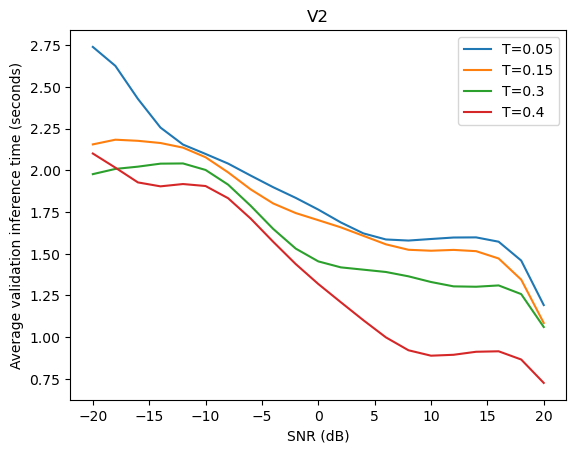

In [219]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(times5['V2'][0.05].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(times5['V2'][0.15].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(times5['V2'][0.3].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(times5['V2'][0.4].values()))
plt.plot(xAxis, y_3[3:])


# Add the vertical line
#plt.axhline(y=2.56, color='red', ls='--')

plt.legend(["T=0.05", "T=0.15", "T=0.3", "T=0.4"])
plt.xlabel("SNR (dB)")
plt.ylabel("Average validation inference time (seconds)")
plt.title("V2")
plt.show()

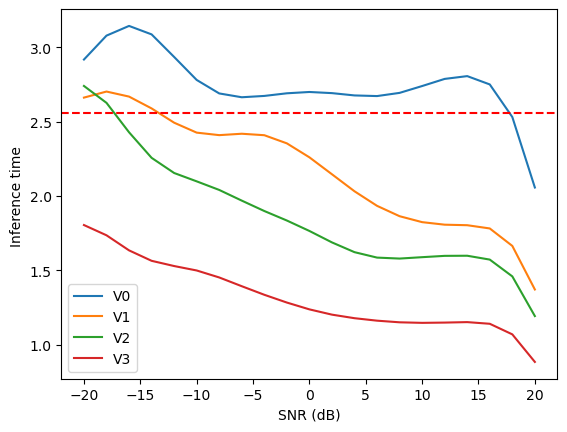

In [223]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(times5['V0'][0.05].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(times5['V1'][0.05].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(times5['V2'][0.05].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(times5['V3'][0.05].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=2.56, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.show()

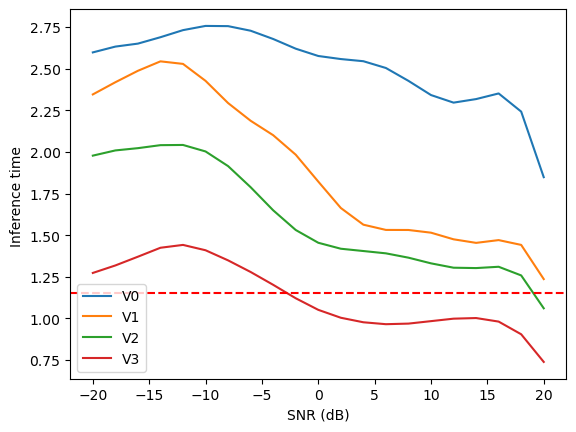

In [231]:
fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(times5['V0'][0.3].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(times5['V1'][0.3].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(times5['V2'][0.3].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(times5['V3'][0.3].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=1.15, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.show()

## 3. Time per branch per model

In [285]:
input_ = torch.randn(1, 2, 128).to(device)
input_.size()

torch.Size([1, 2, 128])

In [361]:
def infer_short(net, sLoader):
        net.eval()
        with torch.no_grad():
            for inputs, gTruth in sLoader:
                inputs, gTruth = inputs.to(device), gTruth.to(device)
                x = net.short_forward(inputs)
                
def infer_long(net, sLoader):
        net.eval()
        with torch.no_grad():
            for inputs, gTruth in sLoader:
                inputs, gTruth = inputs.to(device), gTruth.to(device)
                x = net.long_forward(inputs)

def infer_short2(net, i):
        net.eval()
        with torch.no_grad():
            x = net.short_forward(i)
def infer_long2(net, i):
        net.eval()
        with torch.no_grad():
            x = net.long_forward(i)
                
#times5 = {typ: {thre: {snrV: 0 for snrV in stringSNRs}for thre in thresholds}for typ in ["V0", "V1", "V2", "V3", "V4"]}
V_times = {x:{"short": 0, "long":0} for x in ["V0", "V1", "V2", "V3"]}

# for snr in stringSNRs:

#     tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
#     tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

#     label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
#     tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
#     tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

#     tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    
v0_short, v1_short, v2_short, v3_short = 0, 0, 0, 0
v0_long, v1_long, v2_long, v3_long = 0, 0, 0, 0
N = 20
for _ in range(N):
    # V0
    start_time = time.time()
    infer_short2(eeNet_V0, input_)
    v0_short += time.time() - start_time
            
    start_time = time.time()
    infer_long2(eeNet_V0, input_)
    v0_long += time.time() - start_time
        
    # V1
    start_time = time.time()
    infer_short2(eeNet_V1, input_)
    v1_short += time.time() - start_time
            
    start_time = time.time()
    infer_long2(eeNet_V1, input_)
    v1_long += time.time() - start_time
        
    # V2
    start_time = time.time()
    infer_short2(eeNet_V4, input_)
    v2_short += time.time() - start_time
            
    start_time = time.time()
    infer_long2(eeNet_V4, input_)
    v2_long += time.time() - start_time
        
    # V3
    start_time = time.time()
    infer_short2(eeNet_V2, input_)
    v3_short += time.time() - start_time
            
    start_time = time.time()
    infer_long2(eeNet_V2, input_)
    v3_long += time.time() - start_time
        

    V_times["V0"]["short"], V_times["V1"]["short"], V_times["V2"]["short"], V_times["V3"]["short"] = v0_short/N, v1_short/N, v2_short/N, v3_short/N
    V_times["V0"]["long"], V_times["V1"]["long"], V_times["V2"]["long"], V_times["V3"]["long"] = v0_long/N, v1_long/N, v2_long/N, v3_long/N

        

In [362]:
V_times

{'V0': {'short': 0.0003918766975402832, 'long': 0.0017600297927856446},
 'V1': {'short': 0.0003497838973999023, 'long': 0.0013208985328674316},
 'V2': {'short': 0.0002999067306518555, 'long': 0.0006002426147460937},
 'V3': {'short': 0.0012049674987792969, 'long': 0.0014276862144470214}}

In [363]:
avg_long = sum(V_times[x]["long"] for x in ["V0", "V1", "V2", "V3"])/4
avg_long

0.0012772142887115478

In [270]:
n_samples = 0
for v, l in valLoader:
    n_samples += v.shape[0]
len(valLoader)

76

In [375]:
dbl_calc_time

0.015

In [381]:
bl_time = 100*len(valLoader)*avg_long
bl_time

9.706828594207764

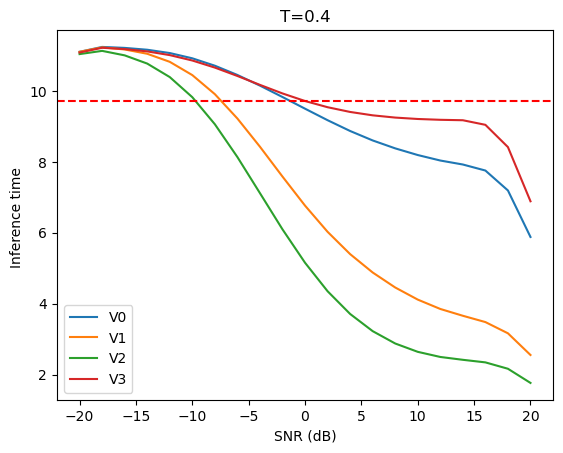

In [383]:
#
Threshold = 0.4
finalTimes = {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]}
dbl_calc_time = 0.00020662546157836914
for Version in ["V0", "V1", "V2", "V3"]:
    for snrV in stringSNRs:
        short_percentage = inferenceCounter[Version][Threshold][0][snrV]
        long_percentage = inferenceCounter[Version][Threshold][1][snrV]
        
        shortTime = int(short_percentage*len(valLoader))*V_times[Version]['short'] 
        
        longTime = long_percentage*len(valLoader)*avg_long  
        longTime += long_percentage*len(valLoader)*dbl_calc_time
        
        finalTimes[Version][snrV] = shortTime + longTime
        #print(snrV, Version, shortTime, longTime, " --> ",finalTimes[Version][snrV])
    #print("==================")

fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(finalTimes['V0'].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(finalTimes['V1'].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(finalTimes['V2'].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(finalTimes['V3'].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=bl_time, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.title("T={}".format(Threshold))
plt.show()

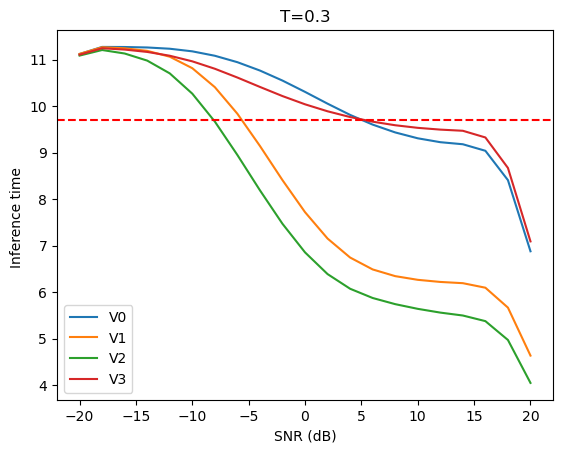

In [384]:
#
Threshold = 0.3
finalTimes = {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]}
dbl_calc_time = 0.00020662546157836914
for Version in ["V0", "V1", "V2", "V3"]:
    for snrV in stringSNRs:
        short_percentage = inferenceCounter[Version][Threshold][0][snrV]
        long_percentage = inferenceCounter[Version][Threshold][1][snrV]
        
        shortTime = int(short_percentage*len(valLoader))*V_times[Version]['short'] 
        
        longTime = long_percentage*len(valLoader)*avg_long  
        longTime += long_percentage*len(valLoader)*dbl_calc_time
        
        finalTimes[Version][snrV] = shortTime + longTime
        #print(snrV, Version, shortTime, longTime, " --> ",finalTimes[Version][snrV])
    #print("==================")

fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(finalTimes['V0'].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(finalTimes['V1'].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(finalTimes['V2'].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(finalTimes['V3'].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=bl_time, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.title("T={}".format(Threshold))
plt.show()

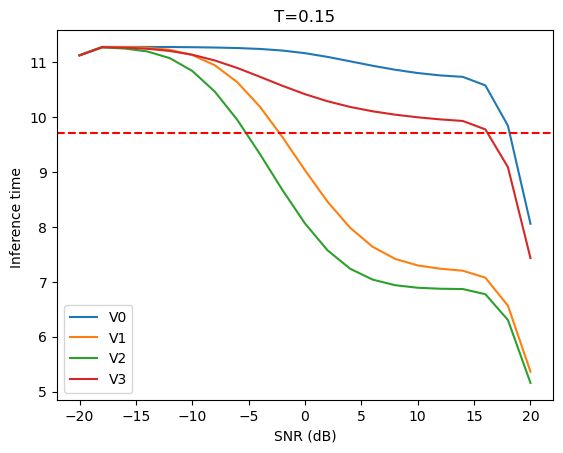

In [387]:
#
Threshold = 0.15
finalTimes = {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]}
dbl_calc_time = 0.00020662546157836914
for Version in ["V0", "V1", "V2", "V3"]:
    for snrV in stringSNRs:
        short_percentage = inferenceCounter[Version][Threshold][0][snrV]
        long_percentage = inferenceCounter[Version][Threshold][1][snrV]
        
        shortTime = int(short_percentage*len(valLoader))*V_times[Version]['short'] 
        
        longTime = long_percentage*len(valLoader)*avg_long  
        longTime += long_percentage*len(valLoader)*dbl_calc_time
        
        finalTimes[Version][snrV] = shortTime + longTime
        #print(snrV, Version, shortTime, longTime, " --> ",finalTimes[Version][snrV])
    #print("==================")

fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(finalTimes['V0'].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(finalTimes['V1'].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(finalTimes['V2'].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(finalTimes['V3'].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=bl_time, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.title("T={}".format(Threshold))
plt.show()

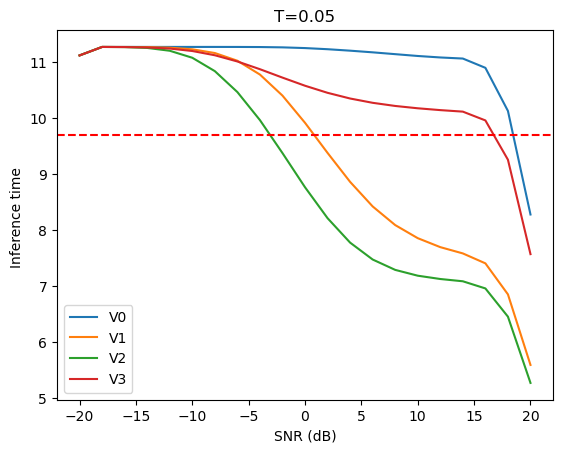

In [386]:
#
Threshold = 0.05
finalTimes = {v:{snrV: 0 for snrV in stringSNRs} for v in ["V0", "V1", "V2", "V3"]}
dbl_calc_time = 0.00020662546157836914
for Version in ["V0", "V1", "V2", "V3"]:
    for snrV in stringSNRs:
        short_percentage = inferenceCounter[Version][Threshold][0][snrV]
        long_percentage = inferenceCounter[Version][Threshold][1][snrV]
        
        shortTime = int(short_percentage*len(valLoader))*V_times[Version]['short'] 
        
        longTime = long_percentage*len(valLoader)*avg_long  
        longTime += long_percentage*len(valLoader)*dbl_calc_time
        
        finalTimes[Version][snrV] = shortTime + longTime
        #print(snrV, Version, shortTime, longTime, " --> ",finalTimes[Version][snrV])
    #print("==================")

fig = plt.Figure()

xAxis = np.arange(-20, 21, 2) #SNRs

x, y_0 = smoothing2(xAxis, list(finalTimes['V0'].values()))
plt.plot(xAxis, y_0[3:])

x, y_1 = smoothing2(xAxis, list(finalTimes['V1'].values()))
plt.plot(xAxis, y_1[3:])

x, y_2 = smoothing2(xAxis, list(finalTimes['V2'].values()))
plt.plot(xAxis, y_2[3:])

x, y_3 = smoothing2(xAxis, list(finalTimes['V3'].values()))
plt.plot(xAxis, y_3[3:])

# Add the vertical line
plt.axhline(y=bl_time, color='red', ls='--')

plt.legend(["V0", "V1", "V2", "V3"])
plt.xlabel("SNR (dB)")
plt.ylabel("Inference time ")
plt.title("T={}".format(Threshold))
plt.show()

## 4. Much Lower T

In [ ]:
# Getting TRAIN data with differebt SNRs values in dB
for snr in stringSNRs:
    
    tmpData = np.array([valXs[i] for i in range(len(valLabels)) if valLabels[i][1]==snr])
    tmpLabels = np.array([valLabels[i][0] for i in range(len(valLabels)) if valLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies["Baseline"][0.05][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        recorder_V0, _, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        accuracies["V0"][thre][snr] = eeAcc_V0

        recorder_V1, _, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        accuracies["V1"][thre][snr] = eeAcc_V1

        recorder_V2, _, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        accuracies["V3"][thre][snr] = eeAcc_V2
        
        recorder_V3, _, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        accuracies["V4"][thre][snr] = eeAcc_V3
        
        recorder_V4, _, eeAcc_V4 = EE_V4.infer(tmpLoader, threshold=thre)
        accuracies["V2"][thre][snr] = eeAcc_V4
    
        for i in range(nBranches):
            inferenceCounter["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter["V3"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter["V4"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100
            inferenceCounter["V2"][thre][i][snr] = len(recorder_V4[i])/(len(recorder_V4[0])+len(recorder_V4[1]))*100
            
    print("Done with SNR = {}".format(snr))